In [21]:
# Google Colab 환경에서 실행하는 경우 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
import json
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


# Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss
# Custom Dataset 정의
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data.astype(np.uint8)  # uint8로 변환
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(x)  # PIL Image로 변환 후 transforms 적용
            x = self.transform(x)

        return x.float().to(device), torch.tensor(y).to(device)

    def __len__(self):
        return len(self.data)


In [23]:
# 데이터 로딩 함수
def unpickle(file):
    with open(file, 'rb') as fo:
        data = np.load(file)
    x, y = data['x'], data['y']
    return x, y

# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 라벨 매핑
label_mapping = {
    0: 'boxes',
    1: 'glass bottles',
    2: 'soda cans',
    3: 'crushed soda cans',
    4: 'water bottles'
}

In [24]:
# 데이터 로딩 및 전처리
train_x, train_y = unpickle('/content/drive/MyDrive/recycled_32/recycled_32_train.npz')
test_x, test_y = unpickle('/content/drive/MyDrive/recycled_32/recycled_32_test.npz')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for param_group in optimizer.param_groups:
    print('Current learning rate:', param_group['lr'])

# transforms 정의 (학습 데이터용 - Data Augmentation 포함)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

# 테스트 데이터용 transform (Data Augmentation 제외)
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Custom dataset 생성 (train_x와 train_y는 numpy array)
train_dataset = MyDataset(train_x.transpose((0, 3, 1 ,2)), train_y,
                          transform=transform_train)
train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True)

test_dataset= MyDataset(test_x.transpose((0,3,1 ,2)), test_y,
                        transform=transform_test)
test_loader= DataLoader(test_dataset,batch_size=batch_size , shuffle=False)

print(train_x.shape)
print(train_dataset[0][0].shape)

Current learning rate: 0.001
(10000, 3, 32, 32)
torch.Size([10000, 3, 32, 32])


In [25]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 파라미터 설정
epochs = 100
batch_size = 64
best_accuracy = 0

# 데이터 로더 설정
train_data = torch.utils.data.TensorDataset(train_x_torch, train_y_torch)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.TensorDataset(test_x_torch, test_y_torch)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

early_stopping = EarlyStopping(patience=5, verbose=True)

# 학습 시작
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x, y = batch
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader)}")

    # 에폭이 끝난 후 테스트 데이터셋에서 성능 평가
    model.eval()
    correct = 0
    total = 0
    test_loss = 0  # 테스트 데이터셋의 손실값을 저장하기 위한 변수
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            outputs = model(x)
            loss = criterion(outputs, y)  # 테스트 데이터셋의 손실값 계산
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after epoch {epoch+1}: {accuracy}%")
    print(f"Test Loss after epoch {epoch+1}: {test_loss/len(test_loader)}")

    # EarlyStopping에 테스트 손실값을 전달
    early_stopping(test_loss/len(test_loader), model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # 최고 정확도 갱신시 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_model.pth")

    scheduler.step()  # 여기에 학습률 스케줄러의 step을 호출합니다.


Epoch [1/100] - Loss: 1.2645043878798272
Test Accuracy after epoch 1: 54.93333333333333%
Test Loss after epoch 1: 1.135761188964049
Validation loss decreased (inf --> 1.135761).  Saving model ...
Epoch [2/100] - Loss: 0.9254557824438545
Test Accuracy after epoch 2: 65.86666666666666%
Test Loss after epoch 2: 0.871084184696277
Validation loss decreased (1.135761 --> 0.871084).  Saving model ...
Epoch [3/100] - Loss: 0.7860944901302362
Test Accuracy after epoch 3: 71.06666666666666%
Test Loss after epoch 3: 0.7668047944704691
Validation loss decreased (0.871084 --> 0.766805).  Saving model ...
Epoch [4/100] - Loss: 0.6654126319535978
Test Accuracy after epoch 4: 72.4%
Test Loss after epoch 4: 0.7120875051865975
Validation loss decreased (0.766805 --> 0.712088).  Saving model ...
Epoch [5/100] - Loss: 0.5928817444546207
Test Accuracy after epoch 5: 74.6%
Test Loss after epoch 5: 0.6276455751309792
Validation loss decreased (0.712088 --> 0.627646).  Saving model ...
Epoch [6/100] - Loss: 0

In [26]:
# 클래스별 정확도 계산
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        outputs = model(x)
        _, predicted = outputs.max(1)
        c = (predicted == y).squeeze()
        for i in range(len(y)):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(5):
    print(f"Accuracy of {label_mapping[i]} : {100 * class_correct[i] / class_total[i]}%")

Accuracy of boxes : 94.66666666666667%
Accuracy of glass bottles : 86.66666666666667%
Accuracy of soda cans : 79.66666666666667%
Accuracy of crushed soda cans : 84.0%
Accuracy of water bottles : 84.66666666666667%


Test Accuracy: 85.93333333333334%
Accuracy of boxes : 94.66666666666667%
Accuracy of glass bottles : 86.66666666666667%
Accuracy of soda cans : 79.66666666666667%
Accuracy of crushed soda cans : 84.0%
Accuracy of water bottles : 84.66666666666667%


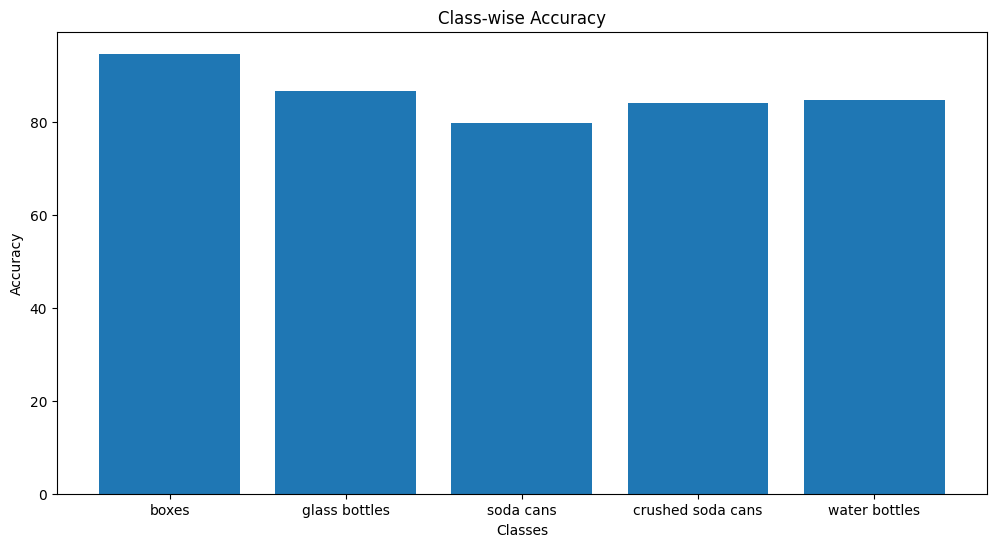

In [27]:
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        outputs = model(x)
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# 시각화
classes = ['boxes', 'glass bottles', 'soda cans', 'crushed soda cans', 'water bottles']
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        outputs = model(x)
        _, predicted = outputs.max(1)
        c = (predicted == y).squeeze()
        for i in range(len(y)):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(5):
    print(f"Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]}%")

# Bar chart로 클래스별 정확도 시각화
plt.figure(figsize=(12, 6))
plt.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(5)])
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy")
plt.savefig("/content/drive/MyDrive/classwise_accuracy.png")
plt.show()


In [28]:
!pip install torchviz

from torchviz import make_dot

# 첫 번째 배치의 데이터를 로드합니다.
first_batch = next(iter(train_loader))
sample_input, _ = first_batch

# forward pass를 실행합니다.
output = model(sample_input.to(device))

# 아키텍처를 그립니다.
dot = make_dot(output, params=dict(model.named_parameters()))

# 이미지로 저장합니다.
dot.format = 'png'
dot.render('/content/drive/MyDrive/model_architecture')

'/content/drive/MyDrive/model_architecture.png'

In [29]:
import os

# 이미지 저장 디렉터리 경로
save_dir = '/content/drive/MyDrive/labelwise_images'
os.makedirs(save_dir, exist_ok=True)  # 디렉터리가 없을 경우 생성

# 각 라벨에 대한 첫 번째 이미지를 불러와 시각화 및 저장
for label, label_name in label_mapping.items():
    # 해당 라벨에 해당하는 첫 번째 이미지의 인덱스 찾기
    idx = np.where(train_y == label)[0][0]
    image = train_x[idx]

    # 이미지 시각화 및 저장
    plt.figure()
    plt.imshow(np.transpose(image, (1, 2, 0)))  # 이미지를 channel-last 형태로 변환하여 시각화
    plt.title(label_name)
    plt.axis('off')
    image_path = os.path.join(save_dir, f"{label_name}.png")
    plt.savefig(image_path)
    plt.close()
    print(f"{label_name} image saved at {image_path}")

boxes image saved at /content/drive/MyDrive/labelwise_images/boxes.png
glass bottles image saved at /content/drive/MyDrive/labelwise_images/glass bottles.png
soda cans image saved at /content/drive/MyDrive/labelwise_images/soda cans.png
crushed soda cans image saved at /content/drive/MyDrive/labelwise_images/crushed soda cans.png
water bottles image saved at /content/drive/MyDrive/labelwise_images/water bottles.png


Image 1 - True Label: boxes, Predicted: soda cans
Image 2 - True Label: boxes, Predicted: crushed soda cans
Image 3 - True Label: boxes, Predicted: crushed soda cans
Image 4 - True Label: boxes, Predicted: glass bottles
Image 5 - True Label: boxes, Predicted: crushed soda cans


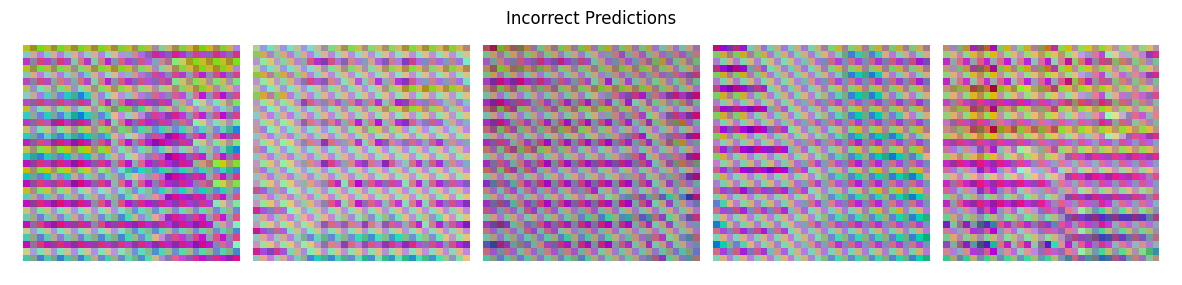

In [30]:
from torchvision.utils import make_grid

# 예측이 잘못된 이미지를 시각화하는 함수
def visualize_incorrect_predictions(model, loader, num_images=5):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            _, predicted = outputs.max(1)
            incorrect_idx = (predicted != y).nonzero(as_tuple=True)[0]
            for idx in incorrect_idx:
                if len(incorrect_images) < num_images:
                    incorrect_images.append(x[idx])
                    incorrect_labels.append(y[idx])
                    incorrect_preds.append(predicted[idx])
                else:
                    break
            if len(incorrect_images) >= num_images:
                break

    # 시각화
    grid = make_grid(incorrect_images, nrow=num_images, normalize=True, pad_value=1)
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Incorrect Predictions")
    for i, (label, pred) in enumerate(zip(incorrect_labels, incorrect_preds)):
        print(f"Image {i+1} - True Label: {label_mapping[label.item()]}, Predicted: {label_mapping[pred.item()]}")
    plt.show()

# 함수 호출
visualize_incorrect_predictions(model, test_loader)
